In [15]:
# Import libraries
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, train_test_split

In [5]:
# Load and combine training datasets
# โหลดข้อมูลการฝึกจากไฟล์ CSV แล้วรวมเข้าด้วยกัน
train_data_part1 = pd.read_csv('TrainData01.csv')
train_data_part2 = pd.read_csv('TrainData02.csv')
train_data = pd.concat([train_data_part1, train_data_part2], ignore_index=True)

# Load test dataset
# โหลดข้อมูลทดสอบ
test_data = pd.read_csv('TestData.csv')

In [6]:
# Add new features
# เพิ่มฟีเจอร์ใหม่
train_data['message_length'] = train_data['cleanMessage'].apply(lambda x: len(str(x)))
test_data['message_length'] = test_data['cleanMessage'].apply(lambda x: len(str(x)))
train_data['word_count'] = train_data['cleanMessage'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['cleanMessage'].apply(lambda x: len(str(x).split()))
train_data['special_char_count'] = train_data['cleanMessage'].apply(lambda x: sum(not c.isalnum() for c in str(x)))
test_data['special_char_count'] = test_data['cleanMessage'].apply(lambda x: sum(not c.isalnum() for c in str(x)))

In [7]:
# Separate features and labels for train and test data
X_train = train_data[['subject', 'email_from', 'email_to', 'cleanMessage', 'message_length', 'word_count', 'special_char_count']]
y_train = train_data['label']
X_test = test_data[['subject', 'email_from', 'email_to', 'cleanMessage', 'message_length', 'word_count', 'special_char_count']]
y_test = test_data['label']

In [8]:
# Combine text fields (subject + email_from + email_to + cleanMessage) into a single field for vectorization
# รวมข้อความจาก 4 คอลัมน์เป็นฟีเจอร์ข้อความเดียว
X_train = X_train.assign(
    text=X_train['subject'] + ' ' + X_train['email_from'] + ' ' + X_train['email_to'] + ' ' + X_train['cleanMessage']
)
X_test = X_test.assign(
    text=X_test['subject'] + ' ' + X_test['email_from'] + ' ' + X_test['email_to'] + ' ' + X_test['cleanMessage']
)

In [9]:
# Replace NaN values with an empty string
# แทนที่ค่าที่เป็น NaN ด้วย string ว่าง
X_train.loc[:, 'text'] = X_train['text'].fillna('')
X_test.loc[:, 'text'] = X_test['text'].fillna('')

In [10]:
# Vectorize the text data using TF-IDF
# ใช้ TF-IDF Vectorizer เพื่อแปลงข้อความเป็นเวกเตอร์
vectorizer = TfidfVectorizer(
    max_features=10000,  # จำนวนฟีเจอร์สูงสุด
    ngram_range=(1, 2),  # ใช้ทั้ง unigrams และ bigrams
    stop_words='english',  # ลบ stop words ทั่วไปในภาษาอังกฤษ
    max_df=0.9,  # ลบคำที่ปรากฏบ่อยเกินไป
    min_df=0.01  # ลบคำที่ปรากฏน้อยเกินไป
)
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_tfidf = vectorizer.transform(X_test['text'])

In [11]:
# Dictionary to store results
# เก็บผลลัพธ์ของโมเดลแต่ละตัว
results = {}

In [12]:
# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    ฝึกและประเมินโมเดล พร้อมคำนวณค่าต่างๆ เช่น Accuracy, Recall, Precision
    """
    start_time = time.time()  # เริ่มจับเวลาการฝึก
    model.fit(X_train, y_train)  # ฝึกโมเดล
    end_time = time.time()  # สิ้นสุดการจับเวลา
    training_time = end_time - start_time  # ระยะเวลาที่ใช้ฝึกโมเดล
    
    y_pred = model.predict(X_test)  # ทำนายผลข้อมูลทดสอบ
    
    # คำนวณ metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return training_time, accuracy, recall, precision, y_pred

In [13]:
# Function to plot learning curve
def plot_learning_curve(model, X, y, model_name):
    """
    แสดงกราฟ Learning Curve เพื่อตรวจสอบการเรียนรู้และการ generalize ของโมเดล
    """
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    # คำนวณค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานของ Training และ Cross-validation scores
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)
    
    # สร้างกราฟ Learning Curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
    plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green', marker='s')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)
    plt.title(f'Learning Curve: {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [16]:
# Train and Evaluate Models
# สร้างโมเดลที่ต้องการใช้ในการทดลอง
models = {
    'Naive Bayes': ComplementNB(),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        ccp_alpha=0.01,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42
    )
}

Learning Curve for Naive Bayes:


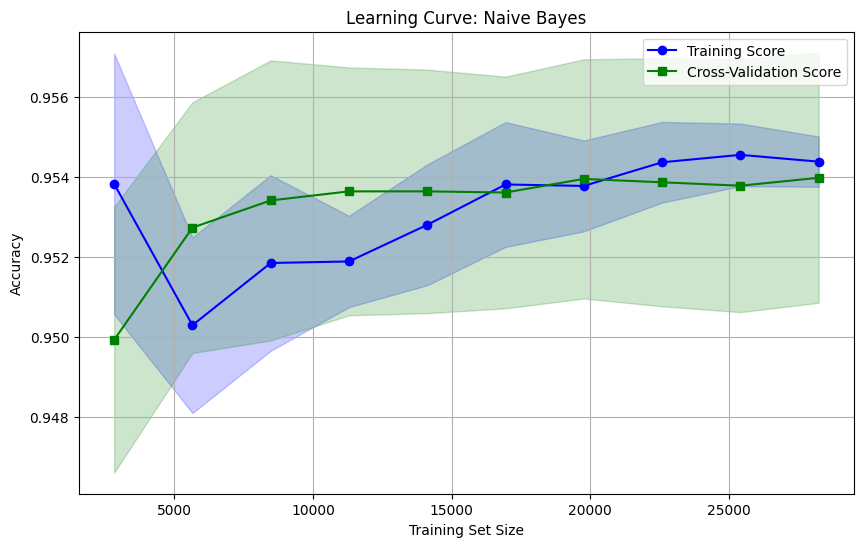

Learning Curve for Decision Tree:


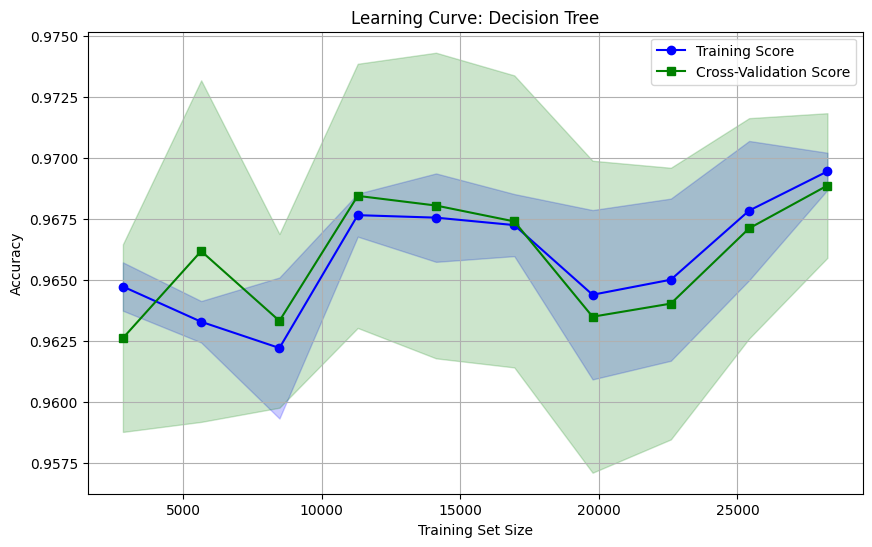

Learning Curve for Random Forest:


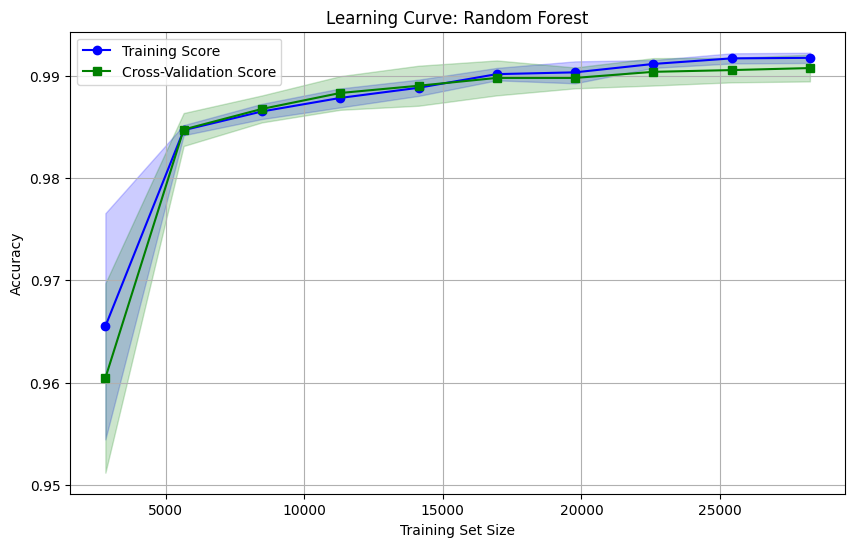

In [17]:
# Train and evaluate models
for model_name, model in models.items():
    results[model_name] = evaluate_model(model, X_train_tfidf, y_train, X_test_tfidf, y_test)
    print(f"Learning Curve for {model_name}:")
    plot_learning_curve(model, X_train_tfidf, y_train, model_name)

In [18]:
# Display Results
# แสดงผลลัพธ์ของโมเดลแต่ละตัว
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Training Time: {result[0]:.4f} seconds")
    print(f"Accuracy: {result[1]:.4f}")
    print(f"Recall: {result[2]:.4f}")
    print(f"Precision: {result[3]:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, result[4])}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, result[4])}\n")

Model: Naive Bayes
Training Time: 0.0436 seconds
Accuracy: 0.9542
Recall: 0.9175
Precision: 0.9902
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      7566
           1       0.99      0.92      0.95      7566

    accuracy                           0.95     15132
   macro avg       0.96      0.95      0.95     15132
weighted avg       0.96      0.95      0.95     15132

Confusion Matrix:
[[7497   69]
 [ 624 6942]]

Model: Decision Tree
Training Time: 4.8720 seconds
Accuracy: 0.9668
Recall: 0.9754
Precision: 0.9589
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      7566
           1       0.96      0.98      0.97      7566

    accuracy                           0.97     15132
   macro avg       0.97      0.97      0.97     15132
weighted avg       0.97      0.97      0.97     15132

Confusion Matrix:
[[7250  316]
 [ 186 7380]]

Model: R